<a href="https://colab.research.google.com/github/dxvsh/LearningPytorch/blob/main/Week5/DLP_Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 5

Install the neceessary libraries:

In [2]:
!pip install transformers datasets torch > /dev/null

In [3]:
from datasets import get_dataset_config_names
from datasets import load_dataset
from pprint import pprint

We are using the [Vox Populi](https://huggingface.co/datasets/facebook/voxpopuli) dataset for our language identification task.

VoxPopuli is a large-scale multilingual speech corpus for representation learning, semi-supervised learning and interpretation. The raw data is collected from the European parliamentary recordings (2009-2020)

VoxPopuli contains labelled (transcribed) data for 18 languages, including English, German, French, Spanish, Polish, Italian and more...



In [5]:
pprint(get_dataset_config_names('facebook/voxpopuli'))

['en',
 'de',
 'fr',
 'es',
 'pl',
 'it',
 'ro',
 'hu',
 'cs',
 'nl',
 'fi',
 'hr',
 'sk',
 'sl',
 'et',
 'lt',
 'en_accented',
 'multilang']


In this Colab, we try to build a language identification system to identify between 3 languages: English, Spanish and Romanian.

We first download the training split of the English subset from the dataset. Note that the language id of English is 0 in the dataset.

The dataset is quite large, so we use the streaming mode.

In [6]:
dataset_en = load_dataset('facebook/voxpopuli', 'en', split='train', streaming=True)

In [7]:
# Only take the first 200 rows
subset = []

for i, example in enumerate(dataset_en):
    if i >= 200:
        break
    subset.append(example)

Now, similar to how we extracted 200 samples from the english dataset, we extract 200 samples each from the spanish and romanian datasets and add them to our manually created subset.

The language id of Spanish is 3 and for Romanian is 6.

In [8]:
dataset_es = load_dataset('facebook/voxpopuli', 'es', split='train', streaming=True)

In [9]:
# append 200 rows for spanish language data in our existing subset:

for i, example in enumerate(dataset_es):
    if i >= 200:
        break
    subset.append(example)

In [10]:
dataset_ro = load_dataset('facebook/voxpopuli', 'ro', split='train', streaming=True)

In [11]:
# append 200 rows of romanian data to our subset consisting of english and spanish data

for i, example in enumerate(dataset_ro):
    if i >= 200:
        break
    subset.append(example)

In [12]:
len(subset)

600

Since we took 200 samples each from the English, Spanish and Romanian sets, we now have 600 samples total in our dataset.

Lets take a look at some samples in our subset to see what they look like:

In [13]:
subset[0]

{'audio_id': '20180418-0900-PLENARY-3-en_20180418-08:50:36_17',
 'language': 0,
 'audio': {'path': 'train_part_0/20180418-0900-PLENARY-3-en_20180418-08:50:36_17.wav',
  'array': array([-0.00030518,  0.00119019,  0.00506592, ..., -0.00036621,
         -0.00027466, -0.00018311]),
  'sampling_rate': 16000},
 'raw_text': 'If you do not address this problem, the ground is there for populist nationalist forces to go on growing all over Europe.',
 'normalized_text': 'if you do not address this problem the ground is there for populist nationalist forces to go on growing all over europe.',
 'gender': 'female',
 'speaker_id': '124737',
 'is_gold_transcript': True,
 'accent': 'None'}

There are various features here, including the language_id, the audio clip, the raw_text transcript of the spoken clip, the gender of the speaker and so on.

You can even listen to the audio in the sample above:

In [14]:
# listen to an audio file on colab

from IPython.display import Audio
Audio(subset[0]['audio']['array'], rate=16000)

Lets try out a spanish sample:

In [15]:
subset[289]

{'audio_id': '20171025-0900-PLENARY-18-es_20171025-15:22:13_4',
 'language': 3,
 'audio': {'path': 'train_part_0/20171025-0900-PLENARY-18-es_20171025-15:22:13_4.wav',
  'array': array([ 1.22070312e-04,  6.10351562e-05, -3.05175781e-04, ...,
         -5.49316406e-04, -3.05175781e-05,  1.19018555e-03]),
  'sampling_rate': 16000},
 'raw_text': 'Algunos creen que llamándole a la inmigración ilegal, están categorizando a los propios seres humanos, como si hubiera categorías de personas legales y personas ilegales.',
 'normalized_text': 'algunos creen que llamándole a la inmigración ilegal están categorizando a los propios seres humanos como si hubiera categorías de personas legales y personas ilegales.',
 'gender': 'female',
 'speaker_id': '4334',
 'is_gold_transcript': True,
 'accent': 'None'}

In [16]:
Audio(subset[289]['audio']['array'], rate=16000)

Currently, all the languages are in a sequence, first english, then spanish and then romanian. Let's shuffle the dataset so any sample can be randomly anywhere

In [17]:
import random
random.shuffle(subset)

Now we use the Wav2Vec model to extract the features from the audio files.

There are two important pieces here, the Wav2Vec Processor and the model:

- **Wav2Vec2Processor**: This is used to prepare the audio data (like converting it into a format the model understands).
- **Wav2Vec2Model**: This is the core machine learning model that will process the audio to extract features.

In [19]:
# loading wav2vec model to extract features from audio files
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# load the wav2vec processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

def extract_wav2vec_features(sample):
    """Takes an audio sample as input and returns the extracted features using the model"""

    inputs = processor(sample['audio']['array'], sampling_rate=16000, return_tensors='pt', padding=True)

    # feed the processed audio inputs to the models for extracting features
    with torch.no_grad():
        outputs = model(**inputs)

    # return the extracted audio features and the language label associated with the clip
    return {'features': outputs.last_hidden_state.squeeze().mean(dim=0).numpy(), 'label': sample['language']}

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# extract_wav2vec_features(subset[0])

Extract wav2vec features from all the samples in the dataset. Takes about half an hour to run since we had 600 samples in the subset

In [20]:
subset_with_features = [extract_wav2vec_features(sample) for sample in subset]

In [21]:
len(subset_with_features)

600

## Train-Test-Val Splits

Now we split the dataset into train, test and validation splits:

In [22]:
from sklearn.model_selection import train_test_split

# split the dataset into train, and test sets
train_data, test_data = train_test_split(subset_with_features, test_size=0.2)

# take the train_data gotten from above and split it further into train and val sets
train_data, val_data = train_test_split(train_data, test_size=0.1)

# now our train set has 432 samples, the test set has 120 samples and the
# validation set has 48 samples

Extract features and labels from the data:

In [23]:
# Extract features and labels from the data
def prepare_data(data):
    features = [sample['features'] for sample in data]
    labels = [sample['label'] for sample in data]
    return torch.tensor(features), torch.tensor(labels)

train_features, train_labels = prepare_data(train_data)
val_features, val_labels = prepare_data(val_data)
test_features, test_labels = prepare_data(test_data)

<ipython-input-23-5cda3cd14d15>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(features), torch.tensor(labels)


In [29]:
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)

Train features shape: torch.Size([432, 768])
Train labels shape: torch.Size([432])


We can see that the train set has 432 samples and each sample's length is 768.

In [30]:
test_features.shape, test_labels.shape

(torch.Size([120, 768]), torch.Size([120]))

In [31]:
val_features.shape, val_labels.shape

(torch.Size([48, 768]), torch.Size([48]))

## Creating a CNN for classification

We're using a CNN for classifying the audio samples. Our input samples are of dimension $768 \times 1$.

In this example, the architecture is as follows:
1. The first layer is a convolutional layer, and we apply 128 filters of size $3 \times 1$, so the output after convolution becomes $128 \times 768 \times 1$. The resulting output has 128 channels (128 stacked feature maps of size $768 \times 1$)

2. Next we apply ReLU to the output and pass it through a Max Pooling layer (with filter_size=2, and stride=2), so the output now becomes: $128 \times 384 \times 1$

3. Again, we pass this output through a second convolution layer (with 256 filters) and then another pooling layer. The output is now of dimensions $256 \times 192 \times 1$

4. We then flatten this output and pass it to a fully connected layer with 128 neurons in the hidden layer, and then pass this to the final output layer with 3 neurons (corresponding to our 3 languages)


Recall the formula for calculating the dimensions after a convolution/pooling operation. Use it to figure out the dimensions after a conv operation:
$$W_2 = \frac{W_1 - F + 2P}{S} + 1$$
<br>
$$H_2 = \frac{H_1 - F + 2P}{S} + 1$$

Carefully note the dimensions in the layers below:

- **Input Size**: The input size of the first fully connected layer is determined by the output size of the previous layer (usually a convolutional layer or a pooling layer).
    - In this code, the input size is calculated as `256 * (input_length // 4)`
        - 256 comes from the out_channels of the second convolutional layer.
        - `input_length // 4` accounts for the reduction in the input size due to the two max-pooling layers, each reducing the size by half. Max Pooling reduces the spatial dimensions of the data.
        - Since the `input_length` is 768, the fully connected layer's input now becomes : 256 * (768/4) = `256 X 192`
- **Output Size**: The output size of a fully connected layer represents the number of neurons in that layer.
    - In `self.fc1`, the output size is set to 128.
    - In `self.fc2`, the output size is set to num_classes, which is the number of language classes the model needs to predict (e.g., 3 for English, Spanish, and Romanian).

In the code:
- `self.fc1 = nn.Linear(256 * (input_length // 4), 128)`: defines the first fully connected layer, taking the flattened output of the convolutional layers as input and producing an output with 128 neurons.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # in_channels : Number of channels in the input image (the input has just one channel initially in this case)
        # out_channels : Number of channels produced by the convolution (essentially, its the number of filters used)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * (input_length // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # define the forward pass computation
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1) # reshapes the data to be fed into the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Diagrammatic representation of the network:

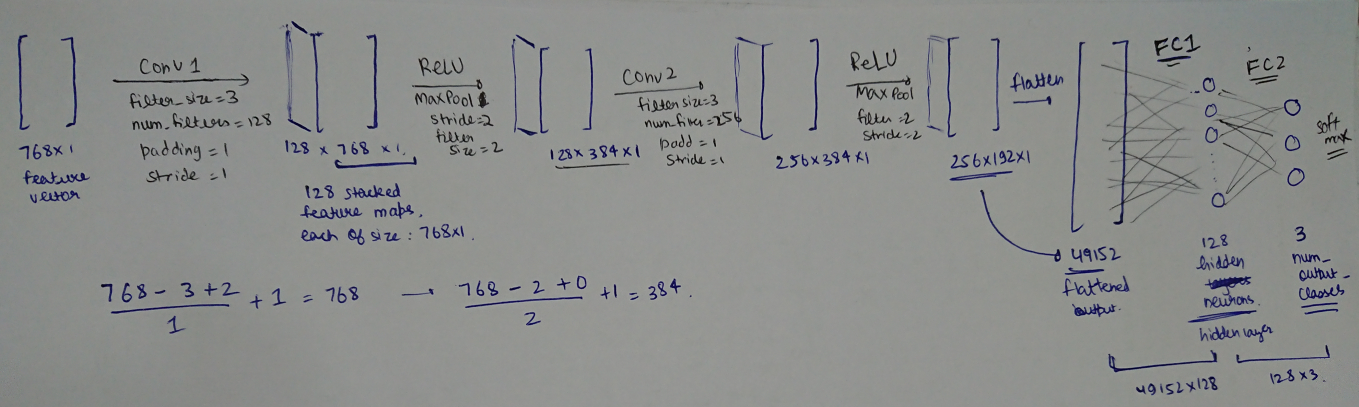

In [33]:
# Assuming train_features and val_features are already loaded
# And they have the shape [num_samples, sequence_length]

input_length = train_features.shape[1] # get the sequence length (768 in this case)

# Assuming we have 3 languages in the dataset, and the original labels are 6, 0, and 3
label_mapping = {6: 0, 0: 1, 3: 2}

# Now Romanian has id : 0
# English has id : 1
# Spanish has id : 2

# Apply the label mapping
train_labels = train_labels.apply_(lambda x: label_mapping[x])
val_labels = val_labels.apply_(lambda x: label_mapping[x])
test_labels = test_labels.apply_(lambda x: label_mapping[x])

# Verify the mapping
unique_train_labels = torch.unique(train_labels)
unique_val_labels = torch.unique(val_labels)
unique_test_labels = torch.unique(test_labels)

print("Unique labels in train_labels:", unique_train_labels)
print("Unique labels in val_labels:", unique_val_labels)
print("Unique labels in test_labels:", unique_test_labels)

Unique labels in train_labels: tensor([0, 1, 2])
Unique labels in val_labels: tensor([0, 1, 2])
Unique labels in test_labels: tensor([0, 1, 2])


In [34]:
# Initialize the model
model = CNNModel(num_classes=3)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    # Set the model to training mode
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features.unsqueeze(1).float()) #inserts a new dimension at pos 1, to represent a channel dimension
    loss = loss_fn(outputs, train_labels)
    loss.backward()
    optimizer.step()

    # Validation
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad(): # disable gradient calculations, we're only interested in inference during eval
        val_outputs = model(val_features.unsqueeze(1).float())
        val_loss = loss_fn(val_outputs, val_labels)

    # print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Epoch 10/100, Training Loss: 0.8892105221748352, Validation Loss: 0.8813310265541077
Epoch 20/100, Training Loss: 0.5620444416999817, Validation Loss: 0.5517228245735168
Epoch 30/100, Training Loss: 0.49488797783851624, Validation Loss: 0.4903845489025116
Epoch 40/100, Training Loss: 0.4363209009170532, Validation Loss: 0.4422999918460846
Epoch 50/100, Training Loss: 0.36873123049736023, Validation Loss: 0.37643492221832275
Epoch 60/100, Training Loss: 0.321517676115036, Validation Loss: 0.31850606203079224
Epoch 70/100, Training Loss: 0.2735132873058319, Validation Loss: 0.29834145307540894
Epoch 80/100, Training Loss: 0.24859966337680817, Validation Loss: 0.23969769477844238
Epoch 90/100, Training Loss: 0.23071172833442688, Validation Loss: 0.216295525431633
Epoch 100/100, Training Loss: 0.2125304937362671, Validation Loss: 0.21566025912761688


In [36]:
# check the number of params in the model:

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 6391043


In [37]:
from sklearn.metrics import accuracy_score

# Ensure your model is in evaluation mode
model.eval()

# Disable gradient computaion
with torch.no_grad():
    # Forward pass to get predictions
    test_outputs = model(test_features.unsqueeze(1).float())

    # Get the predicted class labels
    # torch.max gives both the max val and its index (the label in this case), we're only interested in the label
    _, predicted = torch.max(test_outputs, 1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels.numpy(), predicted.numpy())

# Print the test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 95.00%


Lets test our model on a random sample from the test set, say sample 100

In [38]:
test_features.shape, test_labels.shape

(torch.Size([120, 768]), torch.Size([120]))

Lets try making a prediction for the 100th sample in the test set. The true label is Spanish:

In [41]:
test_labels[100]

tensor(2)

In [54]:
test_features[100].shape

torch.Size([768])

In [55]:
# before making a prediction, need to add additional dimensions to the sample
test_features[100].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 768])

In [50]:
# make a prediction on test_features[100]

model.eval()
with torch.no_grad():
    prediction = model(test_features[100].unsqueeze(0).unsqueeze(0).float())

In [51]:
prediction

tensor([[ 0.7217, -4.1352,  0.8774]])

In [52]:
_, predicted = torch.max(prediction, 1)
print(f"Predicted class: {predicted.item()}, True class: {test_labels[100].item()}")

Predicted class: 2, True class: 2


The model identified the language correctly!